In [1]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

In [5]:
#%cd ..

# Import Data

In [6]:
df, answers, info_dict = get_cluster_input_data(pca_data=False, grouped_data=True)
df.head()

,gender,postnr,region,Q1_1_feel_exposed,Q1_2_covid_is_threat,Q2_1_easy_to_follow_advice,Q2_2_can_follow_advice_if_wanted,Q2_3_if_follow_advice_safe,Q2_4_if_follow_advice_others_safe,Q2_5_follow_advice_relationships_impared,...,Q4_4_nr_contact_strangers,group_q2_following_advice,group_q2_consequence_advice,group_q3_cleaning,group_q3_distancing,group_q5_beh_other,group_q6_opinion,group_q7_symptoms,group_q4_contacts,group_household
0,0,2830,Capital,NaN,4.797035,5.0,7.0,4.0,7.0,4.0,...,0,5.75,4.5,5.5,6.8,5.000000,5.8,0.0,0.00,0.5
1,1,4654,Zealand,3.0,7.000000,7.0,7.0,5.0,7.0,6.0,...,2,6.50,5.5,7.0,7.0,2.500000,6.5,0.0,1.00,0.5
2,1,7451,Central,3.0,7.000000,7.0,7.0,7.0,7.0,4.0,...,0,7.00,3.5,6.0,6.5,5.500000,5.8,0.0,1.25,0.5
3,1,6740,Southern,2.0,2.000000,3.0,3.0,7.0,7.0,1.0,...,0,5.00,1.0,7.0,7.0,4.521673,7.0,0.0,0.00,0.5
4,0,4700,Zealand,6.0,6.000000,1.0,7.0,2.0,1.0,7.0,...,15,2.75,5.5,7.0,6.0,3.500000,4.6,0.0,6.00,0.5


In [7]:
info_dict

{'cluster_input_cols': ['group_q2_following_advice',
  'group_q2_consequence_advice',
  'group_q3_cleaning',
  'group_q3_distancing',
  'group_q5_beh_other',
  'group_q6_opinion',
  'group_q4_contacts'],
 'combined_data': False,
 'data_path': 'data/preprocessing/dim_reduction/220407_grouped_data.csv',
 'grouped_data': True,
 'pca_data': False,
 'scaler_type': 'MinMaxScaler()'}

In [8]:
answers_sampled = pd.DataFrame(answers).sample(50000).to_numpy()

# GM clustering

## Probabilistic Approach to determine number of clusters

### Prior Distribution

In [9]:
from scipy.stats import norm
mean = 2
std = 3
prior_dist = norm(loc=mean, scale=std)

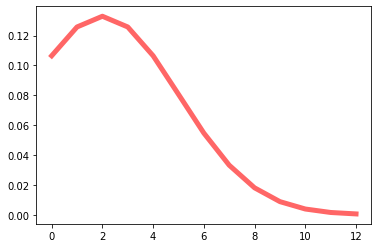

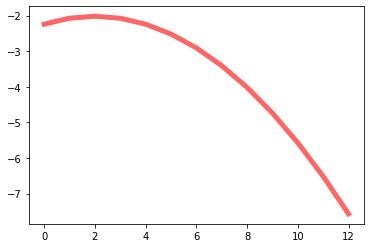

In [10]:
x = np.arange(13)
plt.plot(x, prior_dist.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()
plt.plot(x, prior_dist.logpdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

### Calculate and Plot

In [11]:
# Set up a range of cluster numbers to try
n_range = range(1,15)
list_log_prob_data_given_model = []
list_log_prob_model = []
list_score = []

# Loop through the range and fit a model
for n in tqdm(n_range):
    # init & fit gmm
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=6)
    gm.fit(answers_sampled)
    
    # Calculate Log Probabilities
    log_prob_data_given_model = -gm.bic(answers_sampled) # Computes the per-sample average log-likelihood of the given data X - can be approximated by using BIC Score
    log_prob_model = prior_dist.logpdf(n)

    # Append values to list
    list_log_prob_data_given_model.append(log_prob_data_given_model)
    list_log_prob_model.append(log_prob_model)

100%|██████████| 14/14 [07:20<00:00, 31.45s/it]


In [12]:
def min_max_scaler(input_list):
  input_array = np.array(input_list)
  input_array_scaled = (input_array - input_array.min()) / (input_array.max() - input_array.min())
  return input_array_scaled

In [13]:
log_prob_data_given_model_scaled = min_max_scaler(list_log_prob_data_given_model) # multiply with -1 so that we get a maximization problem
log_prob_model_scaled = min_max_scaler(list_log_prob_model)
score = log_prob_data_given_model_scaled + log_prob_model_scaled
score

array([0.99305556, 1.18835892, 1.22823917, 1.53985352, 1.52328688,
       1.5737645 , 1.52532924, 1.46405407, 1.52525495, 1.44583012,
       1.27818925, 1.18670554, 1.12515904, 1.        ])

Text(0.5, 1.0, 'Probabilistic Evaluation')

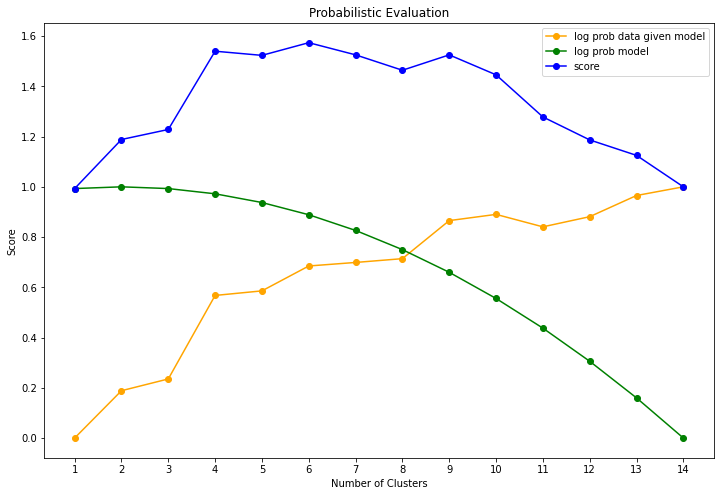

In [14]:
# Plot Probabilistic Evaluation
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, log_prob_data_given_model_scaled, '-o', color='orange', label='log prob data given model')
ax.plot(n_range, log_prob_model_scaled, '-o', color='green', label='log prob model')
ax.plot(n_range, score, '-o', color='blue', label='score')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.legend()
ax.set_title('Probabilistic Evaluation')

In [15]:
n_clusters = n_range[np.argmax(score)]
n_clusters

6

## GM fit with determined number of cluster

In [16]:
n_clusters = 4
gm = GaussianMixture(n_components=n_clusters, 
                         random_state=123, 
                         n_init=6)
gm.fit(answers)

GaussianMixture(n_components=4, n_init=6, random_state=123)

In [17]:
df['group'] = gm.predict(answers)
df['group_prob'] = pd.DataFrame(gm.predict_proba(answers)).max(axis=1)
df.head()

,gender,postnr,region,Q1_1_feel_exposed,Q1_2_covid_is_threat,Q2_1_easy_to_follow_advice,Q2_2_can_follow_advice_if_wanted,Q2_3_if_follow_advice_safe,Q2_4_if_follow_advice_others_safe,Q2_5_follow_advice_relationships_impared,...,group_q2_consequence_advice,group_q3_cleaning,group_q3_distancing,group_q5_beh_other,group_q6_opinion,group_q7_symptoms,group_q4_contacts,group_household,group,group_prob
0,0,2830,Capital,NaN,4.797035,5.0,7.0,4.0,7.0,4.0,...,4.5,5.5,6.8,5.000000,5.8,0.0,0.00,0.5,1,0.982321
1,1,4654,Zealand,3.0,7.000000,7.0,7.0,5.0,7.0,6.0,...,5.5,7.0,7.0,2.500000,6.5,0.0,1.00,0.5,3,0.996639
2,1,7451,Central,3.0,7.000000,7.0,7.0,7.0,7.0,4.0,...,3.5,6.0,6.5,5.500000,5.8,0.0,1.25,0.5,1,0.940911
3,1,6740,Southern,2.0,2.000000,3.0,3.0,7.0,7.0,1.0,...,1.0,7.0,7.0,4.521673,7.0,0.0,0.00,0.5,3,0.999267
4,0,4700,Zealand,6.0,6.000000,1.0,7.0,2.0,1.0,7.0,...,5.5,7.0,6.0,3.500000,4.6,0.0,6.00,0.5,3,0.944679


## Save for general clustering evaluation

In [18]:
df.to_csv('data/clustering/220407_gmm_clustered_grouped_data_2.csv', index=False)

## Dirichlet Process
n_components=20 --> 4 weights that are smaller than 0.01

In [ ]:
n_comp = 10
bgm = BayesianGaussianMixture(n_components=n_comp, random_state=123, n_init=100, weight_concentration_prior_type='dirichlet_process', weight_concentration_prior= 100)
bgm.fit(answers_sampled)

BayesianGaussianMixture(n_components=10, n_init=100, random_state=123,
                        weight_concentration_prior=100)

In [ ]:
DPGMM = BayesianGaussianMixture(n_components=15, 
                                                max_iter=100000000,
                                                n_init=10,
                                                tol=1e-5, 
                                                init_params='kmeans', 
                                                weight_concentration_prior_type='dirichlet_process',
                                                weight_concentration_prior=1/10)
DPGMM.fit(answers_sampled)

BayesianGaussianMixture(max_iter=100000000, n_components=15, n_init=10,
                        tol=1e-05, weight_concentration_prior=0.1)

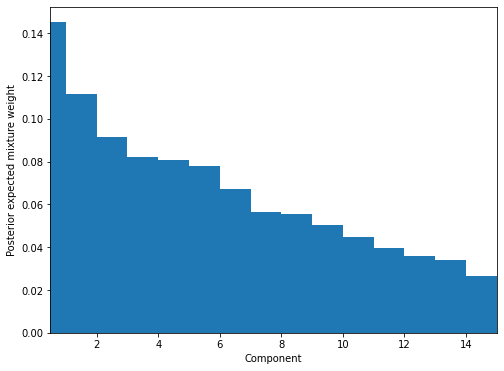

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(15) + 1

ax.bar(plot_w - 0.5, np.sort(DPGMM.weights_)[::-1], width=1., lw=0);

ax.set_xlim(0.5, 15);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [ ]:
#n_to_select = 8
w = (-DPGMM.weights_).argsort()[:n_to_select]

In [ ]:
w

In [ ]:
df['group'] = DPGMM.predict(answers)
df['group_prob'] = pd.DataFrame(DPGMM.predict_proba(answers)).max(axis=1)
df.head()

In [ ]:
mat = []
for ind2 in w:
    p1 = sp.multivariate_normal.pdf(mix,mean=DPGMM.means_[ind2],cov=DPGMM.covariances_[ind2]) + eps
    mat.append(p1)
clusts = pd.DataFrame(mat).T.idxmax(axis=1)

In [ ]:
fig, ax = plt.subplots()


scatter = ax.scatter(X[:, 0], X[:, 1], c=clusts, cmap=plt.cm.viridis, alpha=.25);
plt.title("DPGMM Predicted Labels with %s clusters" %len(np.unique(clusts)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

In [ ]:
bgm.weights_ # 10 comp, weight_concentration_prior = 0.01

array([0.09972451, 0.21158215, 0.02671422, 0.08405336, 0.06169124,
       0.04720168, 0.10768013, 0.14968287, 0.13016821, 0.08150162])

In [ ]:
bgm.means_

array([[5.98973420e-01, 8.27125717e-01, 9.99985800e-01, 8.03490588e-01,
        9.99986485e-01, 5.23705233e-01, 3.84195303e-01, 7.77848472e-01,
        6.73037734e-01, 5.70717866e-01, 7.42757909e-01, 6.81892157e-01,
        6.60773135e-01, 6.09051551e-01, 7.43799172e-01, 2.04374130e-01,
        8.05546728e-01, 5.90505866e-01, 7.47577430e-01, 7.13403989e-01,
        4.79381704e-01, 6.81496596e-01, 4.46020082e-01],
       [6.14103597e-01, 7.18430877e-01, 8.45995352e-01, 7.02855527e-01,
        8.33390187e-01, 6.27353529e-01, 4.89142901e-01, 8.58816394e-01,
        7.48501366e-01, 6.38480870e-01, 8.20576417e-01, 7.39849540e-01,
        7.18544313e-01, 6.99116459e-01, 7.79198550e-01, 2.73167014e-01,
        7.70819149e-01, 5.89461123e-01, 7.30673030e-01, 6.22360378e-01,
        6.22390141e-01, 6.06712979e-01, 9.99829906e-01],
       [5.80270731e-01, 6.63134946e-01, 7.48553556e-01, 6.62096828e-01,
        7.83139966e-01, 5.81117107e-01, 4.66936204e-01, 8.33342114e-01,
        6.95065484e-01

In [ ]:
bgm.n_features_in_

23

# Specific Clustering Method Analysis

In [ ]:
gm.weights_

array([0.28843901, 0.44322344, 0.26833755])

In [ ]:
df['group'].value_counts(dropna=False)

1    54541
0    36294
2    31994
Name: group, dtype: int64

## Group Probability

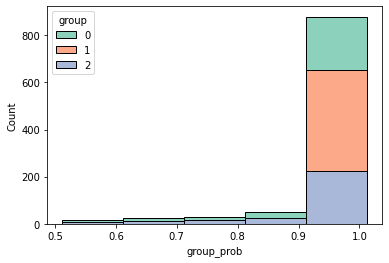

In [ ]:
df_sample = df.sample(1000)
sns.histplot(data=df_sample, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
plt.show()

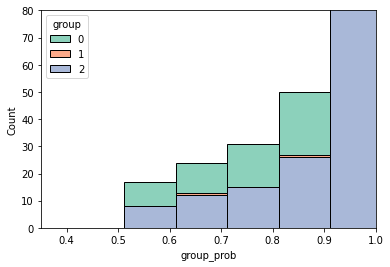

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=df_sample, ax=ax, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
ax.set_xlim(0.35, 1)
ax.set_ylim(0,80)
plt.show()

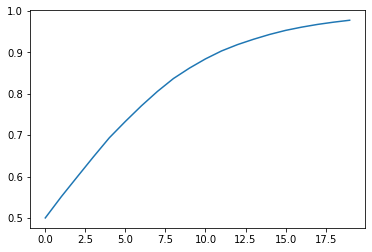

In [ ]:
prob_list = []
for i in np.arange(0, 0.2, 0.01):
  prob = df['group_prob'].quantile(i)
  prob_list.append(prob)

plt.plot(prob_list)
plt.show()